# Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System

The data used here is from Data.gov, managed and hosted by the U.S. General Services Administration, Technology Transformation Service (https://catalog.data.gov)

The dataset includes data on adult's diet, physical activity, and weight status from Behavioral Risk Factor Surveillance System. This data is used for DNPAO's Data, ...

## Setup

First we need to import the some libraries

In [1]:
import json
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt

import networkx as nx

import urllib.request
from xnd import xnd

## Loading Data

The data for this tutorial could be downloaded at https://chronicdata.cdc.gov/views/hn4x-zwk7/rows.json?accessType=DOWNLOAD

We already have this data at `data/data-gov-nutrition.json`

In [2]:
with open('data/data-gov-nutrition.json') as f:
    data = json.load(f)    

In [3]:
sys.getsizeof(data)

240

In [6]:
def walk(G, node):
    if isinstance(node, dict):
        for key, item in node.items():
            if isinstance(item, dict):
                for j in item.keys():
                    G.add_edge(key, j)
                walk(G, item)
    if isinstance(node, list):
        walk(G, node[0])
    return
            
def gen_graph(data):
    G = nx.Graph()
    
    for key in data.keys():
        G.add_edge('ROOT', key)

    walk(G, data)
    
    return G

In [7]:
G = gen_graph(data)

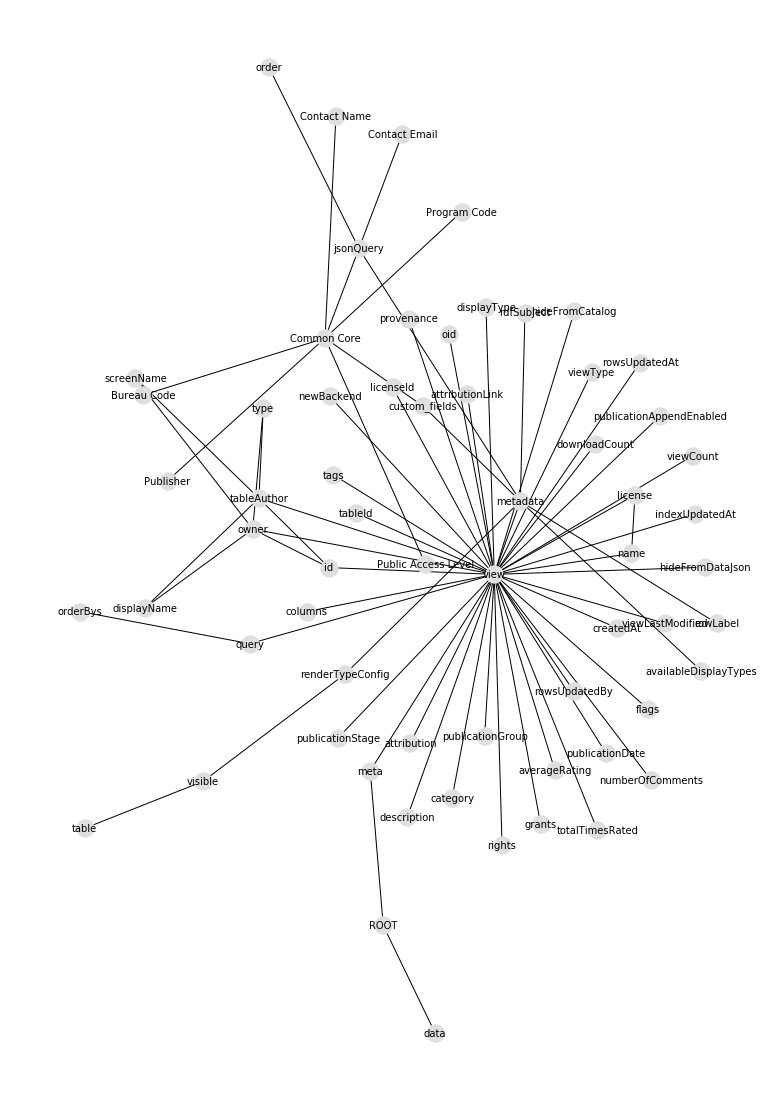

In [8]:
plt.figure(figsize=(10, 15))
nx.draw(
    G, with_labels=True, node_color="#dfdfdf", font_size=10,  
    pos=nx.spring_layout(G, scale=.5, k=0.5)
)

In [9]:
xnd(data)

ValueError: dtype mismatch: have {id: int64, name: string, dataTypeName: string, fieldName: string, position: int64, renderTypeName: string, format: {}, flags: 1 * string} and {id: int64, name: string, dataTypeName: string, description: string, fieldName: string, position: int64, renderTypeName: string, tableColumnId: int64, width: int64, cachedContents: {largest: string, non_null: int64, average: string, null: int64, top: 6 * {item: string, count: int64}, smallest: string, sum: string}, format: {precisionStyle: string, noCommas: string, align: string}}